In [169]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [170]:
from ucimlrepo import fetch_ucirepo
from sklearn import preprocessing
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X = abalone.data.features
y = abalone.data.targets

features = abalone.variables['name']
target = "Rings"

# placeholder for results
results = []

# metadata
print(abalone.metadata)

# variable information
print(abalone.variables)

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [171]:
# Sex only has 3 categories, "M", "F", "I"
# We transform this manually to 0, 1, 2
sex_mapping = {"M": 0, "F": 1, "I": 2}
X["Sex"] = X["Sex"].map(sex_mapping)

C:\Users\User\AppData\Local\Temp\ipykernel_22260\636689041.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Sex"] = X["Sex"].map(sex_mapping)


In [ ]:
# describe data
import seaborn as sns
print(X.describe())
sns.pairplot(X)

In [172]:
# helper functions
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import seaborn as sns

def trainPipelineModel(pipeline, model):
  pipeline.steps.append(('model', model))
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
  pipeline.fit(X_train, y_train)
  return pipeline, X_test, y_test

def displayMetrics(pipeline, X_test, y_test, title, x_labels, y_label):
  y_pred = pipeline.predict(X_test)

  model = pipeline.named_steps['model']

  coef = model.coef_
  mean_se = mean_squared_error(y_test, y_pred)
  root_mean_se = root_mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print("Coefficients: \n", model.coef_)
  print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
  print("Root mean squared error: %.2f" % root_mean_squared_error(y_test, y_pred))
  print("R2: %.2f" % r2_score(y_test, y_pred))

  plt.scatter(y_test, y_pred)
  plt.title(title)
  plt.xlabel("True Values")
  plt.ylabel("Predictions")
  plt.show()

  _, col = X_test.shape
  for i in range(col):
    sns.regplot(x=X_test.iloc[:, i], y=y_test, fit_reg=True)
    plt.gca().get_lines()[0].set_color('red')
    plt.xlabel(features[i])
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

  return coef, mean_se, root_mean_se, r2

def stashResults(title, coef, mean_se, root_mean_se, r2):
  results.append({
    "title": title,
    "coef": coef,
    "mean_se": mean_se,
    "root_mean_se": root_mean_se,
    "r2": r2
  })

Coefficients: 
 [[-0.30353394  0.13911008  1.00218081  0.43532101  5.11536129 -4.99902038
  -1.10054717  1.05608415]]
Mean squared error: 4.77
Root mean squared error: 2.18
R2: 0.52


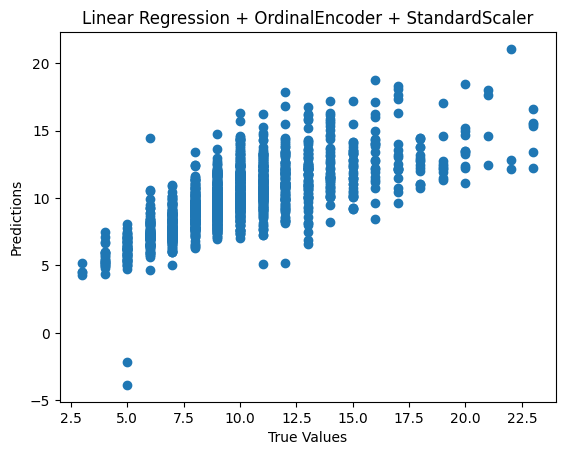

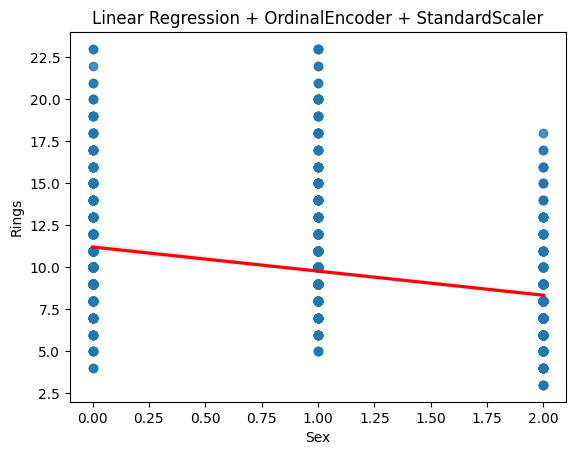

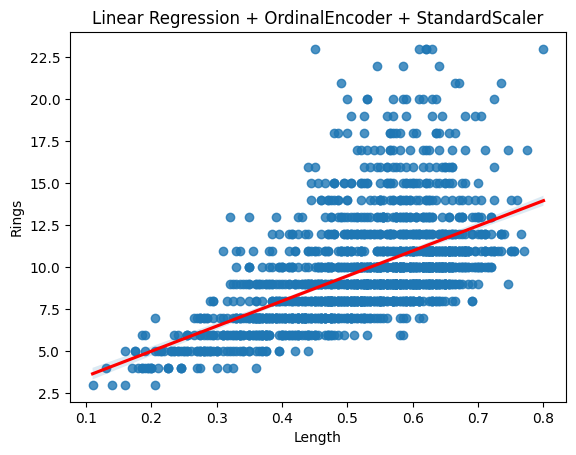

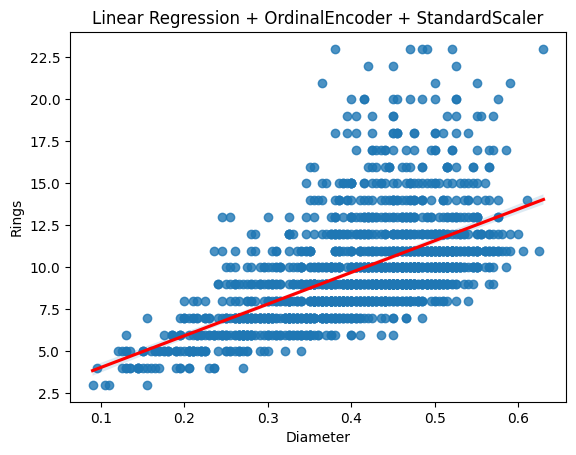

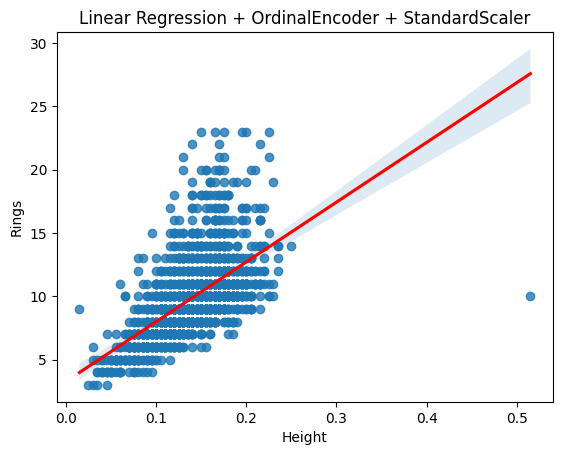

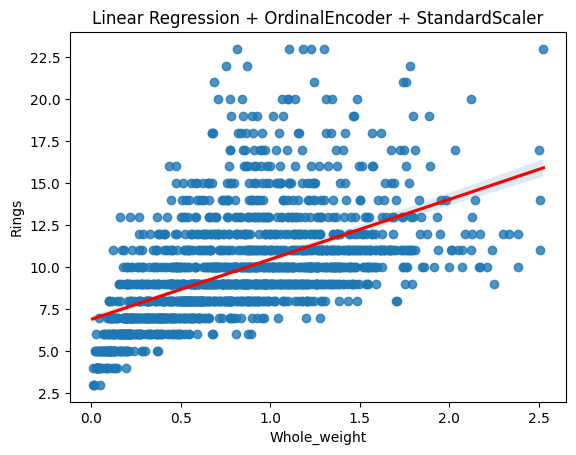

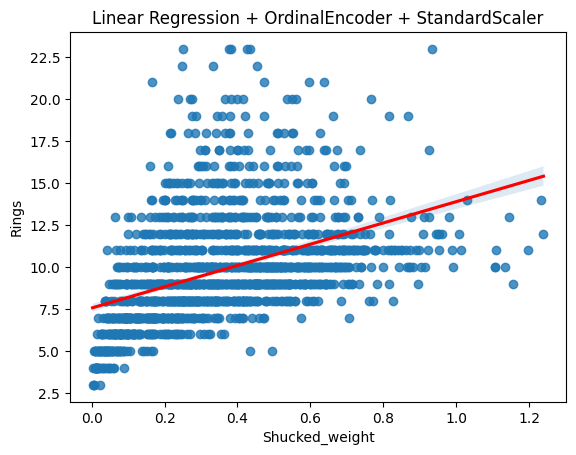

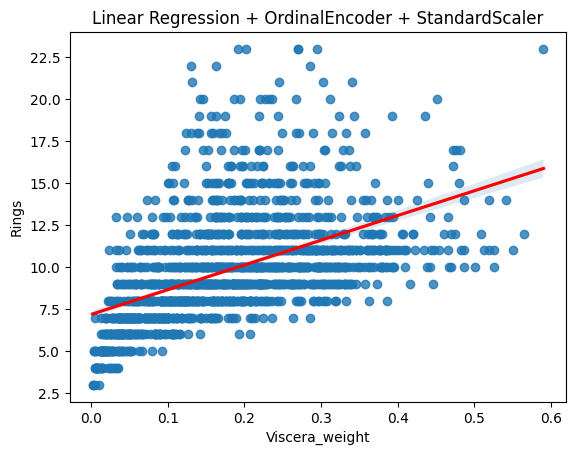

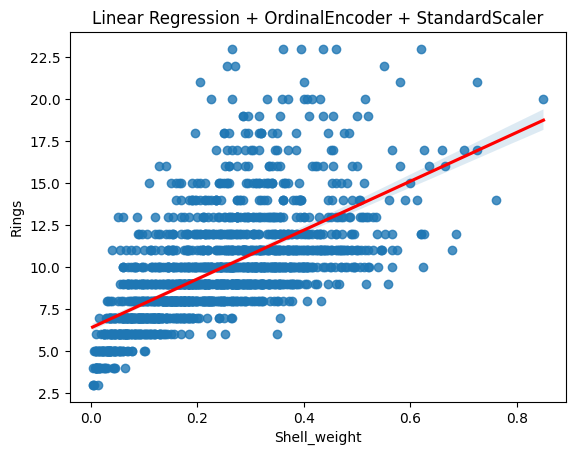

['model1.joblib']

In [173]:
# MODEL PIPELINE
# Linear Regression

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from joblib import dump

pipeline = make_pipeline(
    preprocessing.StandardScaler(),
)

model, X_test, y_test = trainPipelineModel(pipeline, LinearRegression())
title = "Linear Regression + OrdinalEncoder + StandardScaler"
coef, mean_se, root_mean_se, r2 = displayMetrics(pipeline, X_test, y_test, title, features, target)
stashResults(title, coef, mean_se, root_mean_se, r2)

# save via joblib
dump(model, 'model1.joblib')

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients: 
 [[-0.427491    1.22468687  0.53266962 -3.12426967  3.89307058]]
Mean squared error: 5.41
Root mean squared error: 2.33
R2: 0.45


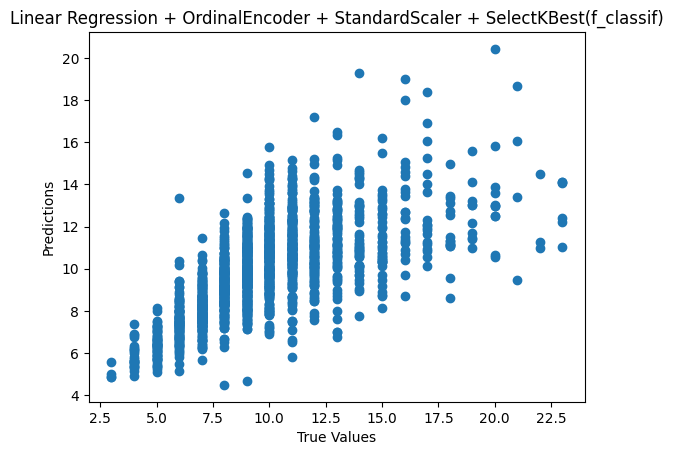

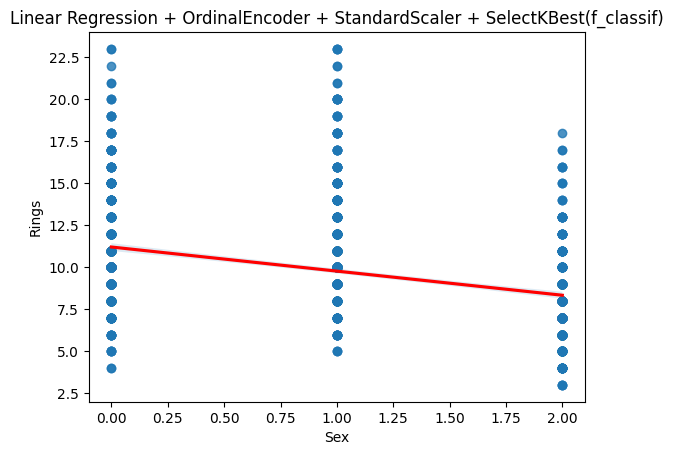

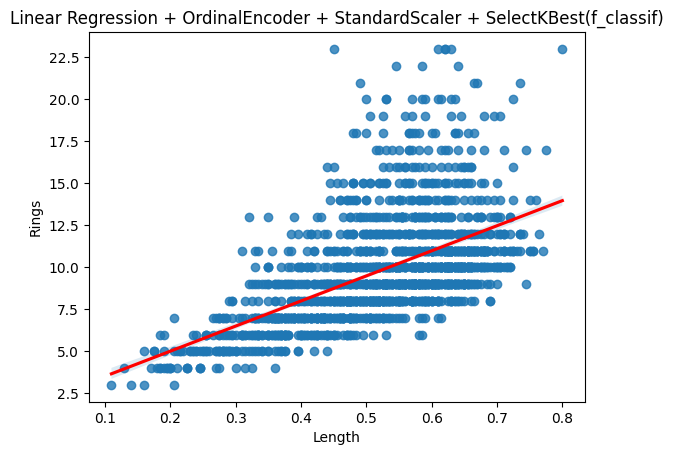

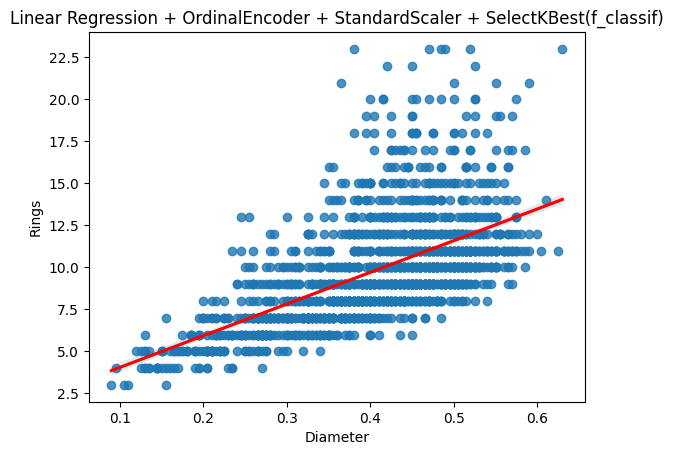

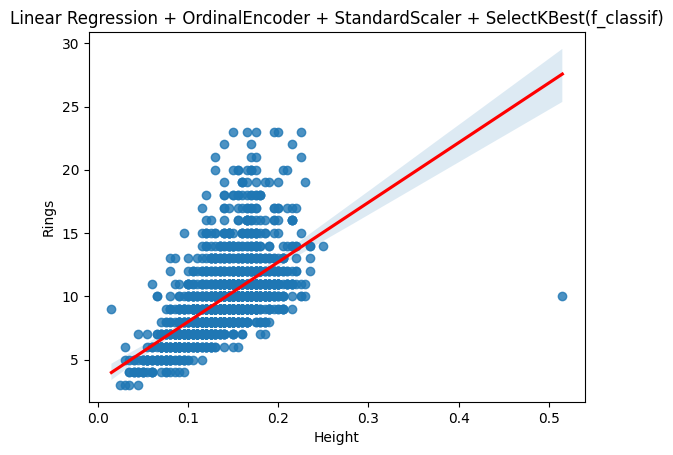

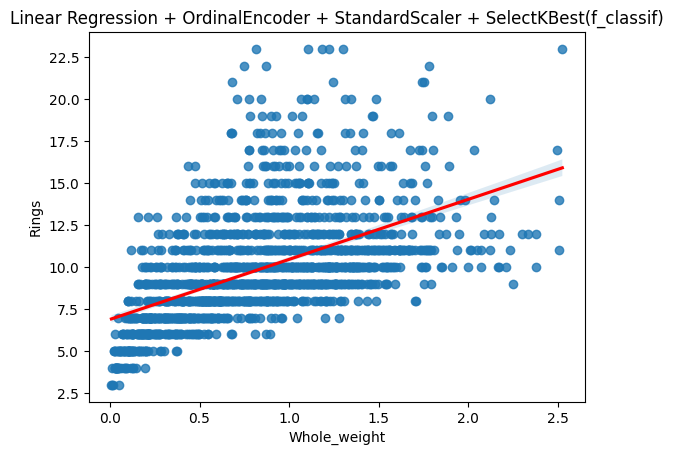

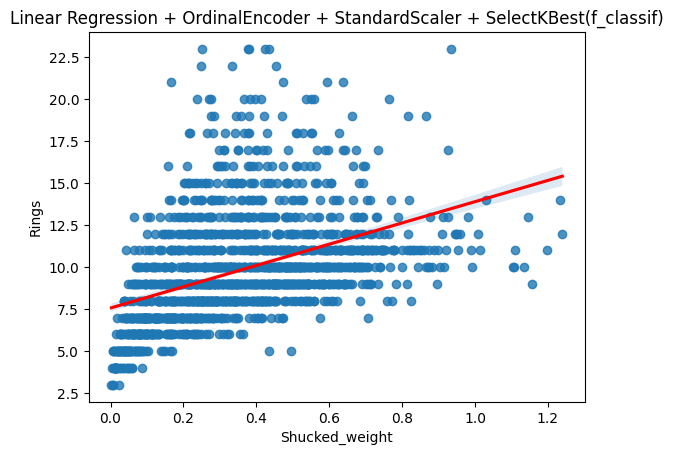

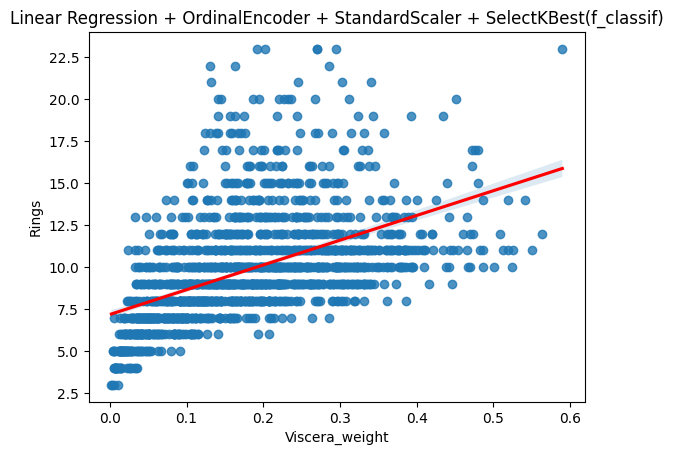

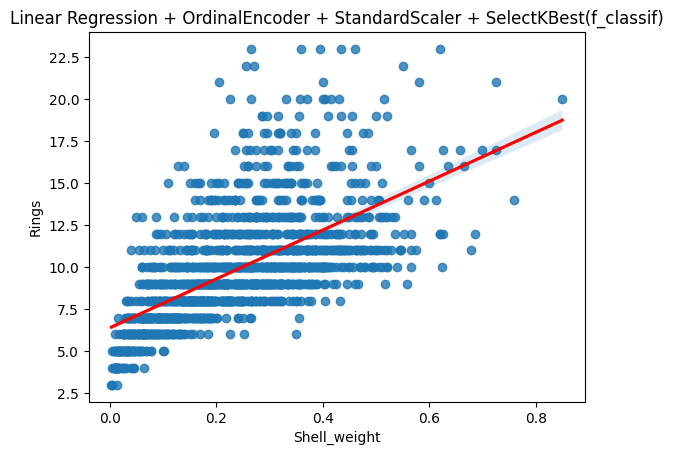

['model2.joblib']

In [174]:
# MODEL PIPELINE
# Linear Regression
# SelectKBest(f_classif)

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif
from joblib import dump

featureSelect = SelectKBest(f_classif, k = 5)
pipeline = make_pipeline(
    preprocessing.StandardScaler(),
    featureSelect
)

model, X_test, y_test = trainPipelineModel(pipeline, LinearRegression())
cols_idxs = featureSelect.get_support(indices=True)
features_df_new = X.iloc[:,cols_idxs]
cols = features_df_new.columns

title = "Linear Regression + OrdinalEncoder + StandardScaler + SelectKBest(f_classif)"
coef, mean_se, root_mean_se, r2 = displayMetrics(model, X_test, y_test, title, cols, target)
stashResults(title, coef, mean_se, root_mean_se, r2)

# save via joblib
dump(model, 'model2.joblib')

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients: 
 [[-0.6237782   1.62431653  1.52766703 -5.05101524  6.65443069]]
Mean squared error: 5.75
Root mean squared error: 2.40
R2: 0.42


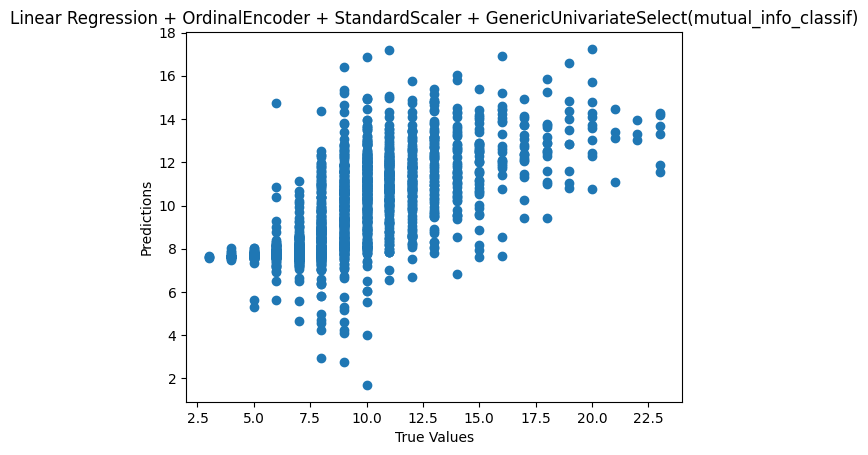

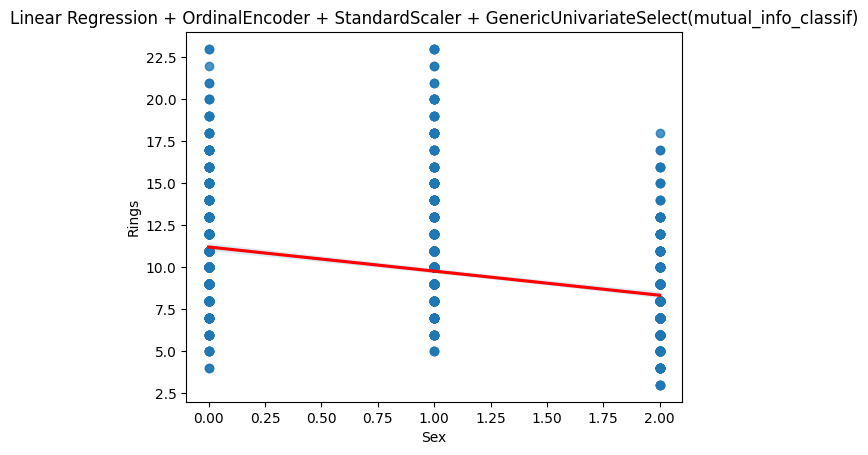

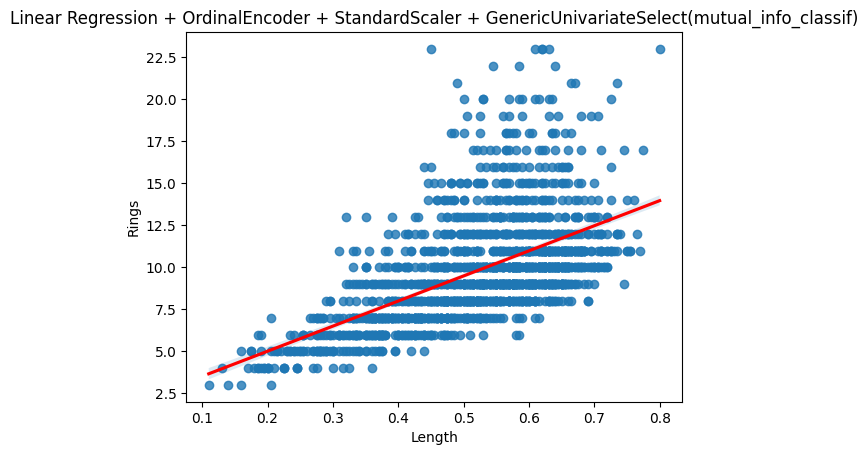

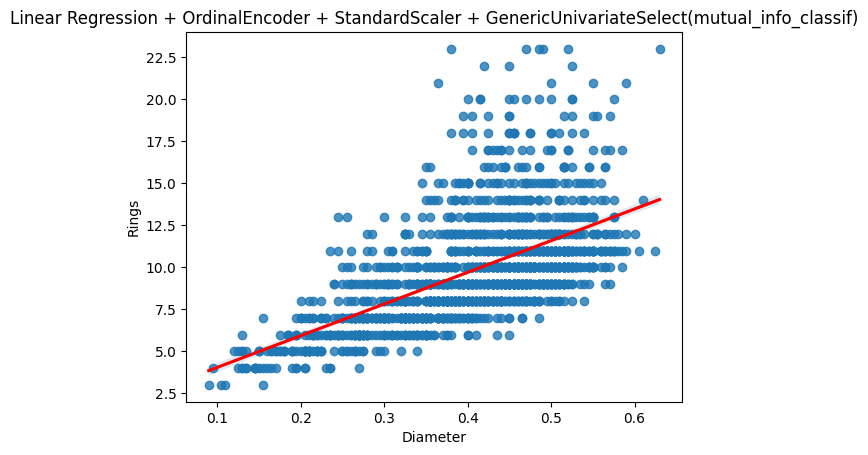

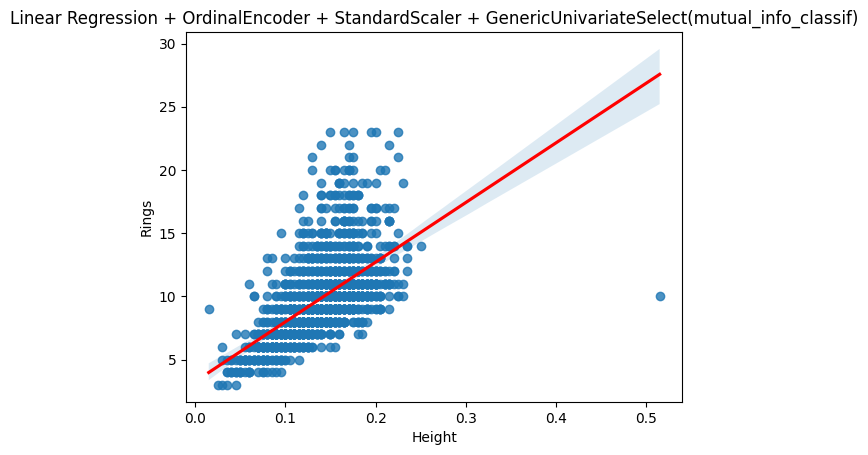

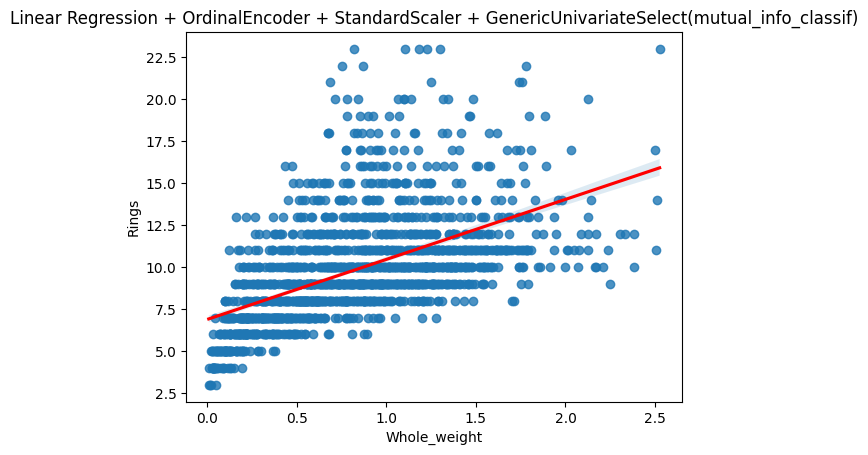

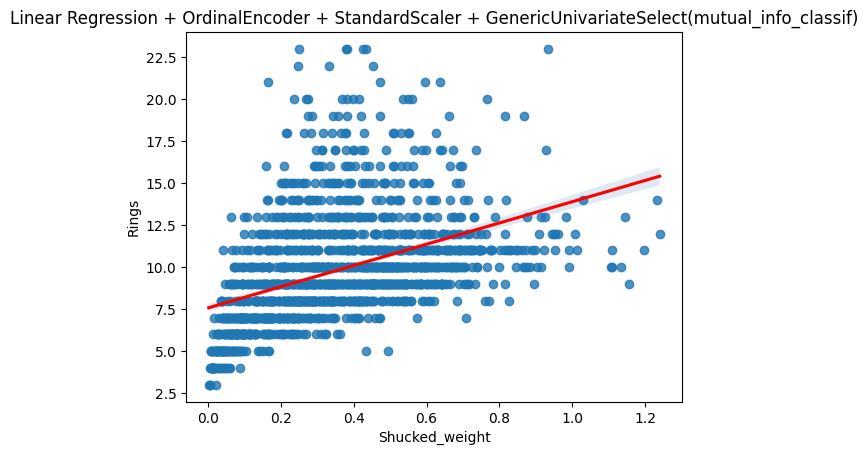

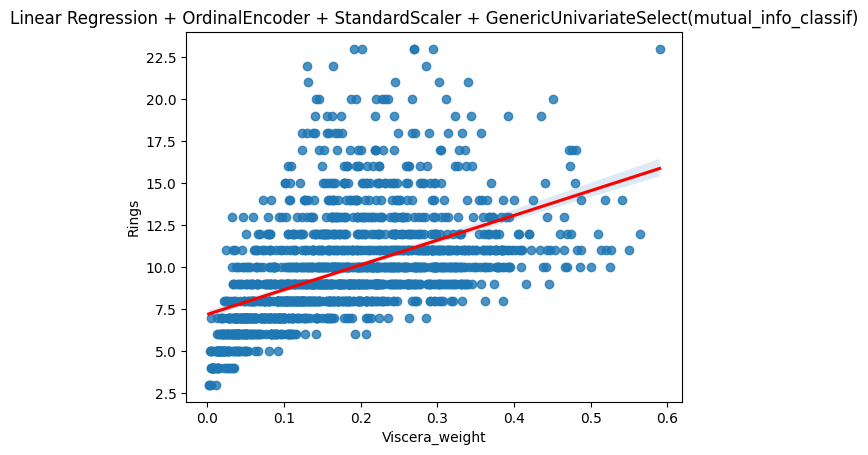

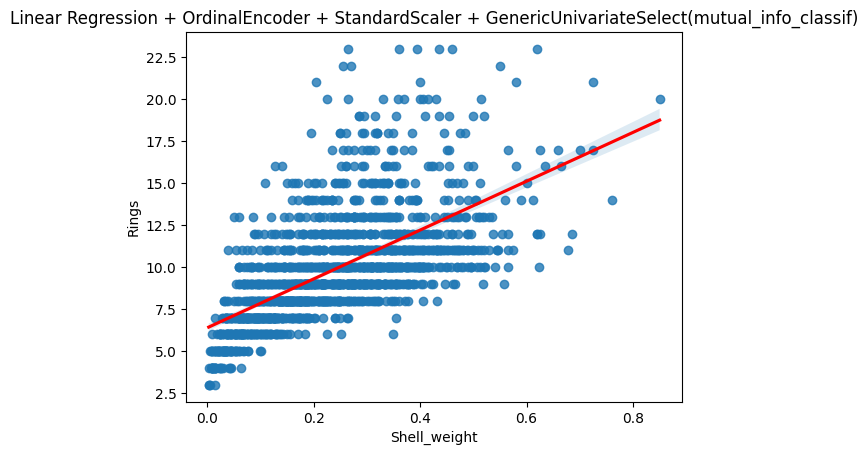

['model3.joblib']

In [175]:
# MODEL PIPELINE
# Linear Regression
# GenericUnivariateSelect(chi2)

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from joblib import dump

featureSelect = GenericUnivariateSelect(mutual_info_classif, mode="k_best", param=5)
pipeline = make_pipeline(
    preprocessing.StandardScaler(),
    preprocessing.Normalizer(),
    featureSelect
)

model, X_test, y_test = trainPipelineModel(pipeline, LinearRegression())
cols_idxs = featureSelect.get_support(indices=True)
features_df_new = X.iloc[:,cols_idxs]
cols = features_df_new.columns

title = "Linear Regression + OrdinalEncoder + StandardScaler + GenericUnivariateSelect(mutual_info_classif)"
coef, mean_se, root_mean_se, r2 = displayMetrics(model, X_test, y_test, title, cols, target)
stashResults(title, coef, mean_se, root_mean_se, r2)

# save via joblib
dump(model, 'model3.joblib')

In [176]:
# print and compare results
for result in results:
    print(result["title"])
    print("Coefficients: ", result["coef"])
    print("Mean squared error: %.2f" % result["mean_se"])
    print("Root mean squared error: %.2f" % result["root_mean_se"])
    print("R2: %.2f" % result["r2"])
    print()

Linear Regression + OrdinalEncoder + StandardScaler
Coefficients:  [[-0.30353394  0.13911008  1.00218081  0.43532101  5.11536129 -4.99902038
  -1.10054717  1.05608415]]
Mean squared error: 4.77
Root mean squared error: 2.18
R2: 0.52

Linear Regression + OrdinalEncoder + StandardScaler + SelectKBest(f_classif)
Coefficients:  [[-0.427491    1.22468687  0.53266962 -3.12426967  3.89307058]]
Mean squared error: 5.41
Root mean squared error: 2.33
R2: 0.45

Linear Regression + OrdinalEncoder + StandardScaler + GenericUnivariateSelect(mutual_info_classif)
Coefficients:  [[-0.6237782   1.62431653  1.52766703 -5.05101524  6.65443069]]
Mean squared error: 5.75
Root mean squared error: 2.40
R2: 0.42



In [177]:
# sanity checks
from joblib import load
print("Sanity checks")

# load model1.joblib
model1 = load('model1.joblib')
y_pred = model1.predict(X_test)
print("Model 1")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: %.2f" % root_mean_squared_error(y_test, y_pred))
print("R2: %.2f" % r2_score(y_test, y_pred))
print()

# load model2.joblib
model2 = load('model2.joblib')
y_pred = model2.predict(X_test)
print("Model 2")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: %.2f" % root_mean_squared_error(y_test, y_pred))
print("R2: %.2f" % r2_score(y_test, y_pred))
print()

# load model3.joblib
model3 = load('model3.joblib')
y_pred = model3.predict(X_test)
print("Model 3")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: %.2f" % root_mean_squared_error(y_test, y_pred))
print("R2: %.2f" % r2_score(y_test, y_pred))
print()

Sanity checks
Model 1
Mean squared error: 4.77
Root mean squared error: 2.18
R2: 0.52

Model 2
Mean squared error: 5.41
Root mean squared error: 2.33
R2: 0.45

Model 3
Mean squared error: 5.75
Root mean squared error: 2.40
R2: 0.42

